In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import scanpy as sc
import numpy as np
import scvi
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Global seed set to 0


In [3]:
adata = sc.read_h5ad("/storage/groups/ml01/workspace/dominik.klein/scMultiome_NVF/scMultiome_NVF_E14-E15/E14-E15_adata_GEX_with_umap.h5ad")

In [4]:
#adata.obs['time'] = adata.obs.apply(lambda x: 0 if x["sample"]=="E14.5" else 1, axis=1)

# scVI on GEX space

In [4]:
adata

AnnData object with n_obs × n_vars = 16978 × 14663
    obs: 'n_counts', 'sample', 'int_id', 'reporter', 'log_cell_probs', 'cell_barcodes_du', 'cell_barcodes_cr', 'cell_barcodes', 'log_counts', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'total_counts_rank', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'log_nCount_ATAC', 'log_nFeature_ATAC', 'scrublet_scores', 'scrublet_doublets', 'scrublet_doublets_cat', 'dd_doublets', 'dd_scores', 'dd_log_p_values', 'dd_voting_average', 'dd_-log_p_values', 'dd_doublets_cat', 'pANN', 'DF_classifications_1', 'DF_classifications_2', 'pANN_SCT', 'DF_SCT_classifications_1', 'DF_SCT_classifications_2', 'df_doublets',

In [5]:
# adata.layers["sct_counts"] contains the non-transformed counts.
adata.layers["sct_counts"].A

array([[0., 0., 0., ..., 5., 0., 0.],
       [0., 1., 1., ..., 3., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 2., 0., 0.]], dtype=float32)

In [6]:
adata.layers["counts"] = adata.layers["sct_counts"]

In [7]:
np.isfinite(adata.layers["counts"].A).all()

True

In [8]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=True,
    layer="counts",
    flavor="cell_ranger"
)


In [9]:
scvi.model.SCVI.setup_anndata(adata, layer="counts")

In [10]:
vae = scvi.model.SCVI(adata)
vae.train()


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/home/icb/dominik.klein/miniconda3/envs/moscot_env_05/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:61: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/icb/dominik.klein/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)


Epoch 400/400: 100%|██████████| 400/400 [06:58<00:00,  1.05s/it, loss=1.14e+03, v_num=1]


In [11]:
adata.obsm["X_scVI"]=vae.get_latent_representation()
adata.layers["scvi_normalized"] = vae.get_normalized_expression()


In [12]:
adata.obsm["X_scVI_pca"] = sc.pp.pca(adata.obsm["X_scVI"])

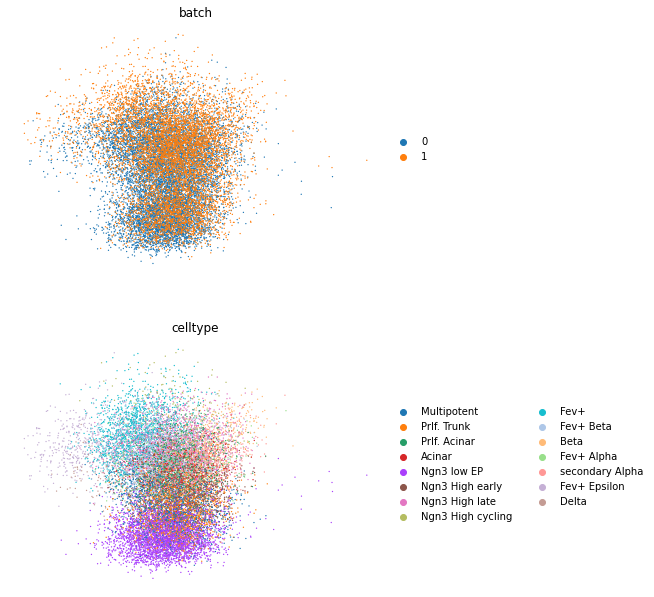

In [13]:
sc.pl.embedding(
    adata,
    basis="X_scVI",
    color=["batch", "celltype"],
    frameon=False,
    ncols=1,
)

In [14]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, key_added="scVI")

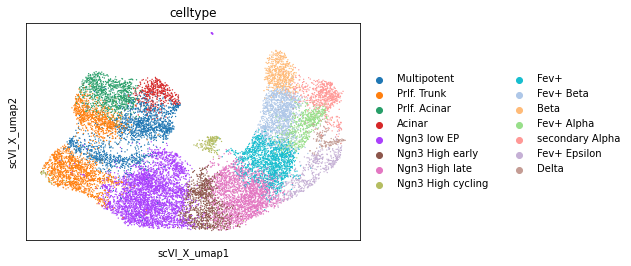

In [15]:
sc.pl.umap(adata, umap_key="scVI_X_umap", color=["celltype"])

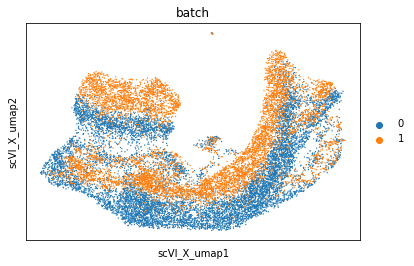

In [16]:
sc.pl.umap(adata, umap_key="scVI_X_umap", color=["batch"])

In [34]:
de_df = vae.differential_expression(
    groupby="celltype",
)
de_df.head()

DE...: 100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
Slit3,0.9780,0.0220,3.794467,0.002215,0.000687,0.0,0.25,3.507118,3.917024,2.531648,...,4.234721,1.340197,0.818916,0.186303,23.630482,6.364360,True,Multipotent vs Rest,Multipotent,Rest
Olfr1369-ps1,0.9762,0.0238,3.713981,0.000031,0.000012,0.0,0.25,3.456529,3.825036,3.148299,...,0.006344,0.002296,0.004037,0.001181,0.038361,0.011247,True,Multipotent vs Rest,Multipotent,Rest
Chst9,0.9758,0.0242,3.696905,0.000015,0.000226,0.0,0.25,-3.412549,-3.704616,2.780521,...,0.010957,0.397858,0.009804,0.158751,0.065194,1.957571,True,Multipotent vs Rest,Multipotent,Rest
Gm6999,0.9722,0.0278,3.554525,0.000002,0.000044,0.0,0.25,-4.021904,-4.200257,3.112836,...,0.002307,0.052217,0.002307,0.032931,0.012933,0.263424,True,Multipotent vs Rest,Multipotent,Rest
Ccbe1,0.9722,0.0278,3.554525,0.001150,0.000347,0.0,0.25,3.703222,4.224517,2.686678,...,1.837945,0.621884,0.628028,0.159210,10.238145,2.957645,True,Multipotent vs Rest,Multipotent,Rest


In [36]:
de_df.columns

Index(['proba_de', 'proba_not_de', 'bayes_factor', 'scale1', 'scale2',
       'pseudocounts', 'delta', 'lfc_mean', 'lfc_median', 'lfc_std', 'lfc_min',
       'lfc_max', 'raw_mean1', 'raw_mean2', 'non_zeros_proportion1',
       'non_zeros_proportion2', 'raw_normalized_mean1', 'raw_normalized_mean2',
       'is_de_fdr_0.05', 'comparison', 'group1', 'group2'],
      dtype='object')

In [38]:
markers = {}
cats = adata.obs.celltype.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:3]

In [39]:
markers

{'Multipotent': ['Slit3', 'Ccbe1', 'Lrrc7'],
 'Prlf. Trunk': ['Mis18bp1', 'Esco2', 'Depdc1a'],
 'Prlf. Acinar': ['Cpb1', '2210010C04Rik', 'Cela2a'],
 'Acinar': ['Cela2a', 'Cpb1', 'Cela3b'],
 'Ngn3 low EP': ['Gm14226', 'Gm35533', 'Adamts16'],
 'Ngn3 High early': ['Map1b', 'Cadps', 'Bcl2'],
 'Ngn3 High late': ['Wnt3', 'Notum', 'Scube1'],
 'Ngn3 High cycling': ['Ckap2l', 'Nusap1', 'Cdc25c'],
 'Fev+': ['Sulf1', 'Pcsk2', 'Clstn2'],
 'Fev+ Beta': ['Tac1', 'Lmo3', 'Slc30a8'],
 'Beta': ['Gm31218', 'Sytl4', 'Mapt'],
 'Fev+ Alpha': ['Gm13629', 'Scn9a', 'Slc38a11'],
 'secondary Alpha': ['Gcg', 'Cltrn', 'Pou6f2'],
 'Fev+ Epsilon': ['Mboat4', 'Lrrtm3', 'Irs4'],
 'Delta': ['Ppy', 'Nap1l5', 'Arg1']}

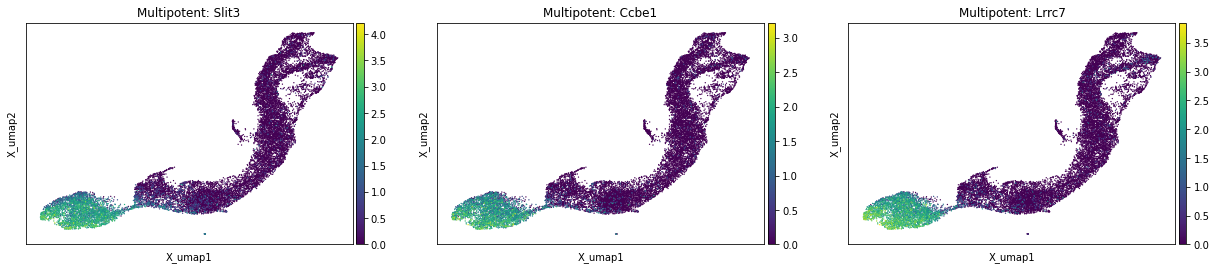

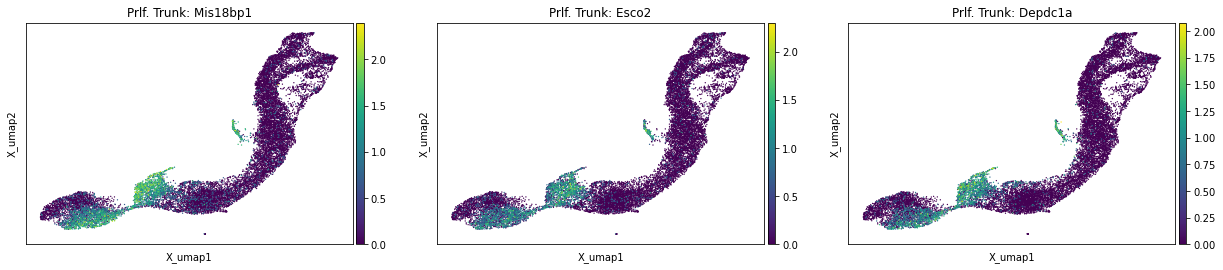

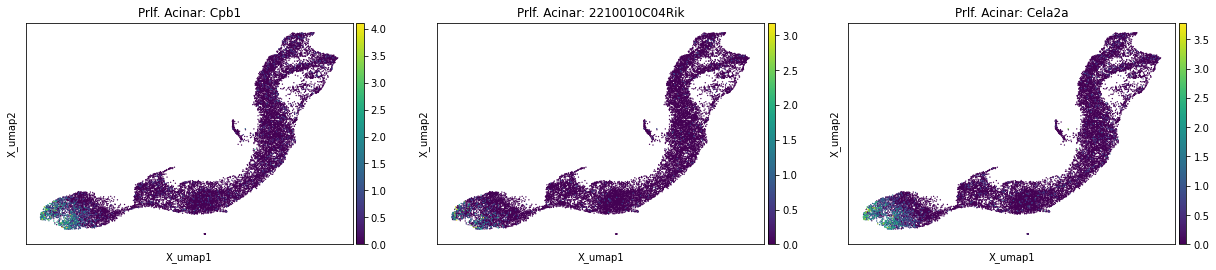

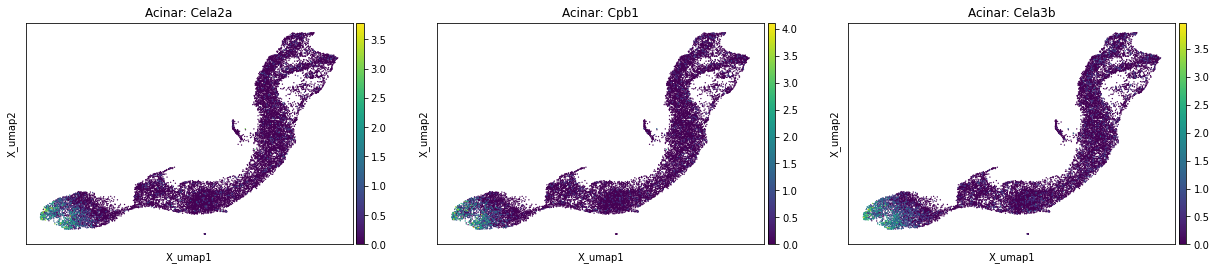

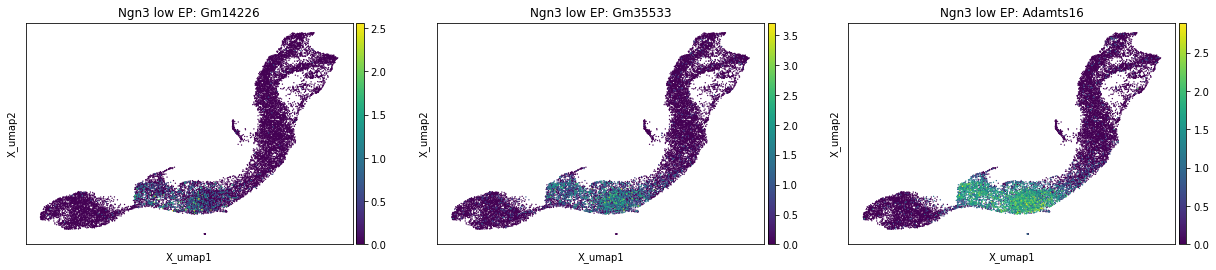

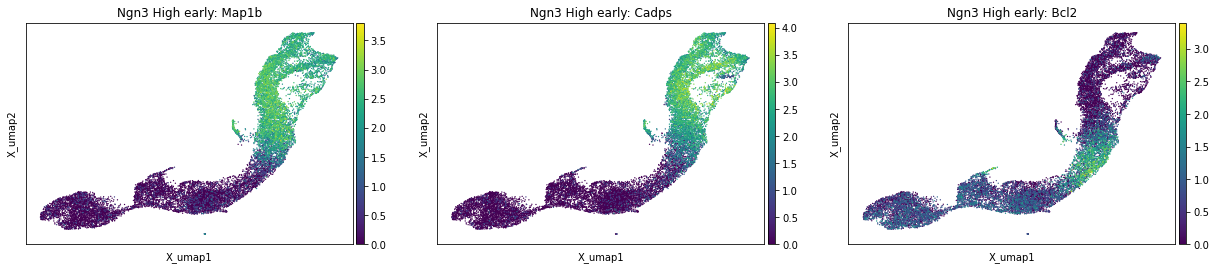

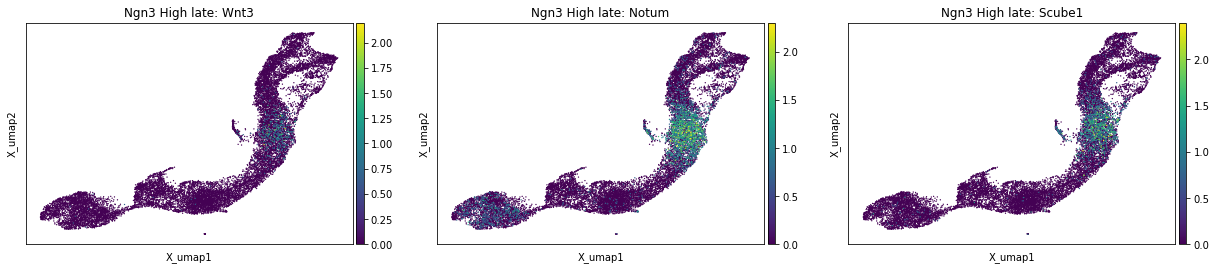

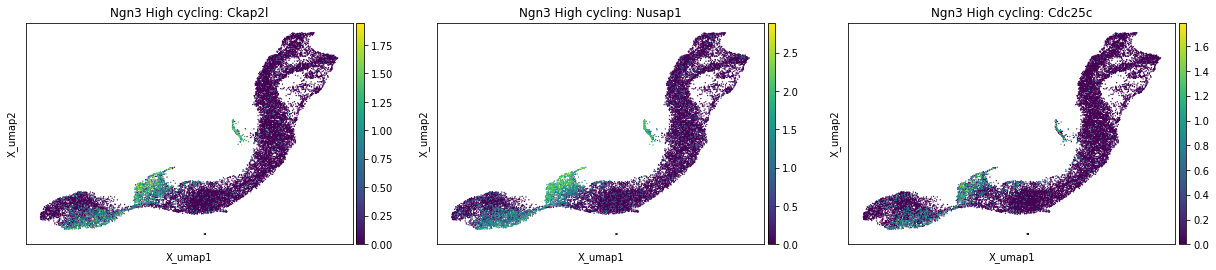

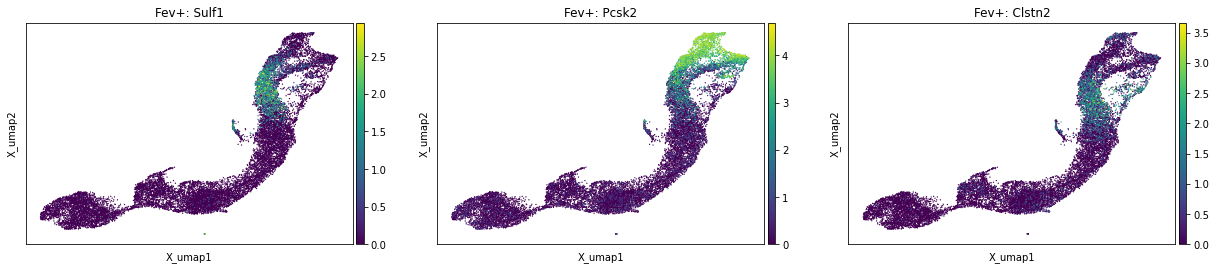

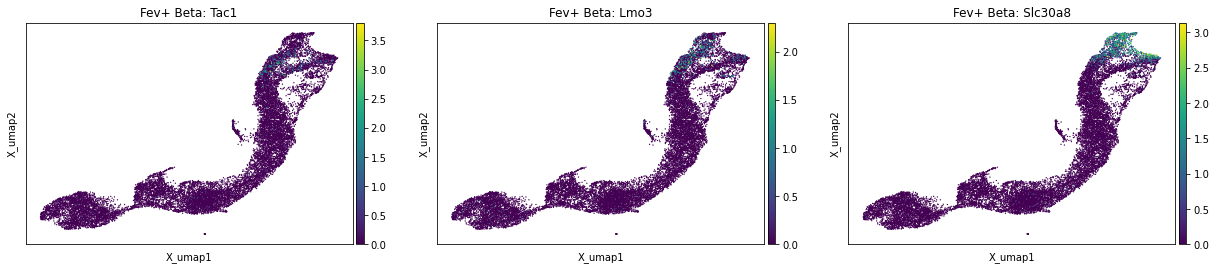

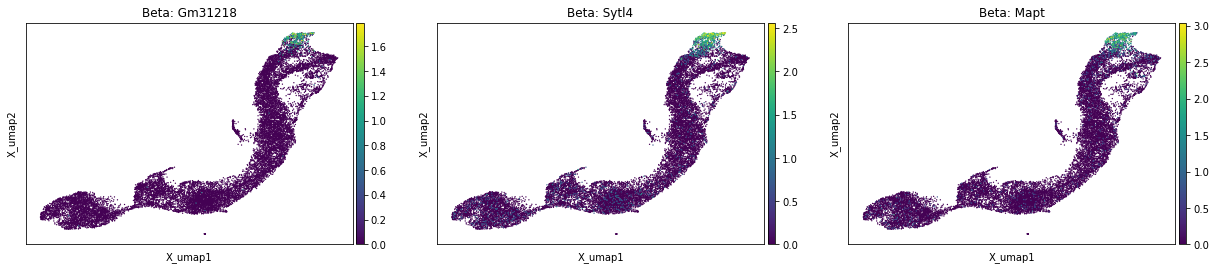

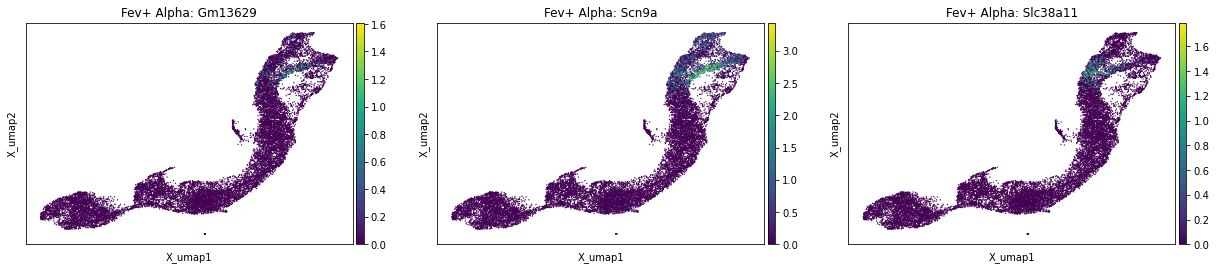

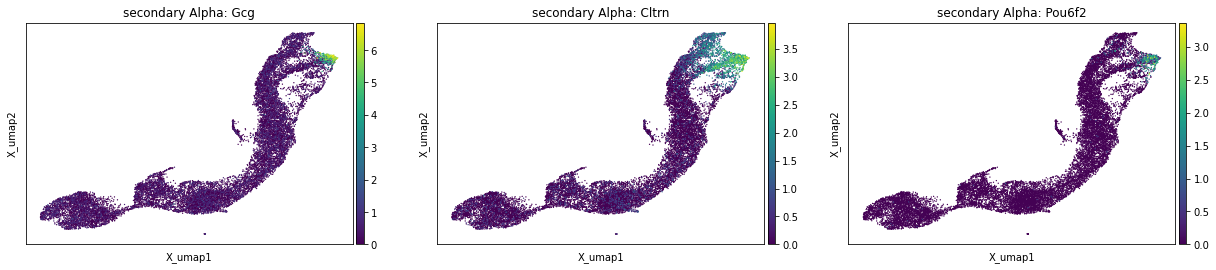

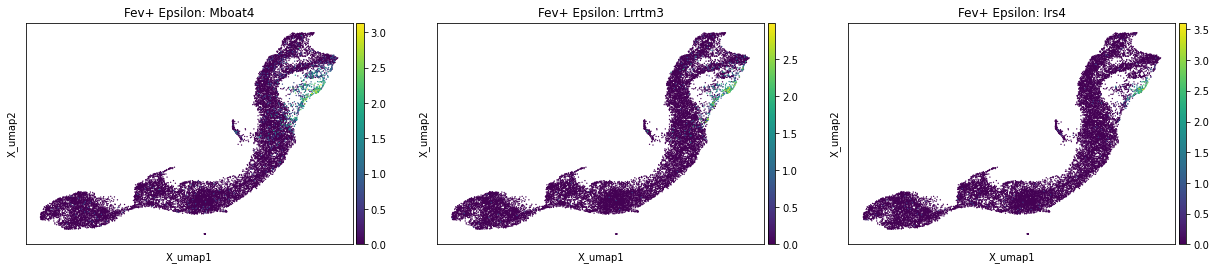

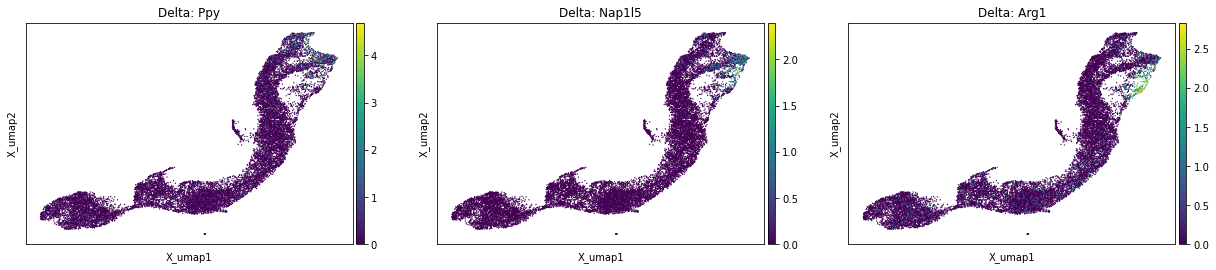

In [55]:
for celltype, marks in markers.items():
    title = [f"{celltype}: {mark}" for mark in marks]
    sc.pl.umap(adata, umap_key="X_umap", color=marks, title=title)

In [17]:
adata

AnnData object with n_obs × n_vars = 16978 × 2000
    obs: 'n_counts', 'sample', 'int_id', 'reporter', 'log_cell_probs', 'cell_barcodes_du', 'cell_barcodes_cr', 'cell_barcodes', 'log_counts', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'total_counts_rank', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'log_nCount_ATAC', 'log_nFeature_ATAC', 'scrublet_scores', 'scrublet_doublets', 'scrublet_doublets_cat', 'dd_doublets', 'dd_scores', 'dd_log_p_values', 'dd_voting_average', 'dd_-log_p_values', 'dd_doublets_cat', 'pANN', 'DF_classifications_1', 'DF_classifications_2', 'pANN_SCT', 'DF_SCT_classifications_1', 'DF_SCT_classifications_2', 'df_doublets', 

In [18]:
adata.write("/storage/groups/ml01/workspace/dominik.klein/scMultiome_NVF/scMultiome_NVF_E14-E15/E14-E15_adata_with_scVI_embedding.h5ad")

In [19]:
bdata = sc.read_h5ad("/storage/groups/ml01/workspace/dominik.klein/scMultiome_NVF/scMultiome_NVF_E14-E15/E14-E15_adata_with_scVI_embedding.h5ad")

In [20]:
cdata = sc.read_h5ad("/storage/groups/ml01/workspace/dominik.klein/scMultiome_NVF/scMultiome_NVF_E14-E15/E14-E15_adata_with_scVI_embedding.h5ad")